In [22]:
#%matplotlib notebook
import os
from datetime import datetime
from pathlib import Path
import math
import time
import numpy as np
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt
import functools
import json

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import importlib
import plt_utils as pu
import evaluator as ev
import SMOTER as smtr
import forecasting_models as fmod
import relevance as rlv
import prepare_data as dprep
import GAN as gmod

#allows update import custom modules without having to restart kernel:
importlib.reload(pu)
importlib.reload(ev)
importlib.reload(smtr)
importlib.reload(fmod)
importlib.reload(rlv)
importlib.reload(dprep)
importlib.reload(gmod)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

**Importing Data**

In [23]:
#If tvar and/or fvars not specified it'll just opt for the default specified by meta
def import_data(file_name, tvar=None, fvars=None):
    with open('data/meta.json','r') as file:
        meta = json.load(file)
    meta = meta[file_name]
    ds_name = meta['name']
    if file_name == 'london_merged.csv':
        #this dataset is multi-variate, can call this function with specified targets/features or just use defaults
        if not tvar: tvar = meta['tv']
        if not fvars: fvars = [tvar]
        df=pd.read_csv(f"data/{file_name}")
        df=df.reset_index()[fvars if tvar in fvars else [tvar] + fvars]
    else:
        #rest of the datasets are univariate and don't have headers
        tvar = meta['tv']
        fvars = [tvar]
        df=pd.read_csv(f"data/{file_name}", header=None, names=[tvar])
    return df, tvar, fvars, ds_name

#importing london_merged:
DATA_FILE = 'london_merged.csv'
df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)

#importing baseline:
#DATA_FILE = 'sunspot.dat'
#df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)

N_FVARS = len(FVARS)
print(df1)

       Bike Share Count
0                   182
1                   138
2                   134
3                    72
4                    47
...                 ...
17409              1042
17410               541
17411               337
17412               224
17413               139

[17414 rows x 1 columns]


In [24]:
FORECASTERS = ["LSTM", "CNN"]

In [25]:
import recorder as rec
importlib.reload(rec)
to_save = {'forecast_models': False,
           'forecast_results': False,
           'resample_models': False, #best GANs 
           'resample_results': True,
           'eval_results': True, #evaluation metrics
           'logs': True,
           'figures': True,
           'parameters': True,
          }

RECORDER = rec.ExperimentRecorder(to_save, "Bike", FORECASTERS)
#LOADER = rec.ExperimentLoader(to_load, "Bike")
#load results from a previous session to compare with results from this session
#base_results_dir must contain resampling results and eval results to combine results
COMBINE_RESULTS_DIR = None #"Sessions/Bike/2023-October-13 13-41-03-532984"

#set GAN_DIR to none to train a new GAN, else give it a folder path to load from
GAN_CNN_DIR = None
GAN_FNN_DIR = None
#GAN_FNN_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\resample_models")

#set FORECAST_DIR to none to train a new LSTM, else give it a folder path to load from
FORECAST_DIR = None
#FORECAST_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\forecast_models")
loadedModels = {"loadedModels": {"GanCnnDir": GAN_CNN_DIR, "GanFnnDir":GAN_FNN_DIR, "ForecastDir": FORECAST_DIR}}
RECORDER.save_param_dict(loadedModels)

**Prepare Data for Resampling/Training**
* Split dataset into train and test split
* Convert data into Taken embedded time series format

In [26]:
RECORDER.log_print(f"Using data from: {DATA_FILE}")
RECORDER.log_print(f"Using feature variables: {FVARS} to predict target variable: '{TVAR}'")
RECORDER.save_param_dict({"importingData":{"dataFile":DATA_FILE,"targetVar":TVAR,"featVars":FVARS}})

df1 = np.array(df1).reshape(-1,N_FVARS)

scaler=MinMaxScaler(feature_range=(0,1))
df1 = df1.reshape(-1,N_FVARS)
scaled_data = scaler.fit_transform(df1) 
print(f"scaled_data: {scaled_data.shape}")

#Prep Data
N_STEPS_IN = 5
N_STEPS_OUT = 5
SPLIT_RATIO = 0.7
SAMPLE_DIM = N_STEPS_IN*N_FVARS + N_STEPS_OUT

k_X, X_train, Y_train, X_test, Y_test = dprep.split_data(scaled_data, N_STEPS_IN, N_STEPS_OUT, FVARS, N_FVARS, TVAR, SPLIT_RATIO)

RECORDER.save_param_dict({"prepData":{"nStepsIn":N_STEPS_IN,"nStepsOut":N_STEPS_OUT,"splitRatio":SPLIT_RATIO}})
RECORDER.log_print(f"Embedding steps in: {N_STEPS_IN} and steps out: {N_STEPS_OUT}")
RECORDER.log_print(f"Split dataset with training ratio: {SPLIT_RATIO}")
RECORDER.log_print(f"""Split data shapes:\n\t X_train: {X_train.shape}\n\t Y_train: {Y_train.shape}\n\t X_test: {X_test.shape}\n\t Y_test: {Y_test.shape}\n\t k_X: {k_X.shape}""")

LOG: 00:25:42:806 Using data from: london_merged.csv

LOG: 00:25:42:806 Using feature variables: ['Bike Share Count'] to predict target variable: 'Bike Share Count'

scaled_data: (17414, 1)
LOG: 00:25:42:812 Embedding steps in: 5 and steps out: 5

LOG: 00:25:42:812 Split dataset with training ratio: 0.7

LOG: 00:25:42:812 Split data shapes:
	 X_train: (12183, 5, 1)
	 Y_train: (12183, 5)
	 X_test: (5222, 5, 1)
	 Y_test: (5222, 5)
	 k_X: (12183, 10)



**Relevance**

In [27]:
#give this guy a list of training target values and it will give you a function that you can input target values to get a relevance score
def getPoisRelFunc(y):
    sample_mean = np.mean(y) 
    sample_std = np.std(y)
    rel_quant = np.quantile(1/rlv.dpois(y,sample_mean),0.5)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"Pois","funcParams":{}}})
    return functools.partial(rlv.poisRelevance, smean=sample_mean, sstd=sample_std, rshift=rel_quant)
    
def getPCHIPRelFunc(y, percs, rels):
    pchip = rlv.PCHIP_interpolator(y, percs, rels)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"PCHIP","funcParams":{"percentages":list(percs),"rels":list(rels)}}})
    return functools.partial(rlv.PCHIPRelevance, pchip_func=pchip)

all_train_targets = np.append(Y_train[:,0],Y_train[-1,1:]) 
#RELEVANCE_THRESHOLD = 0.31
#RELEVANCE_FUNCTION = getPoisRelFunc(all_train_targets)
RELEVANCE_THRESHOLD = 0.7
pchip_percentiles = [25,95,99]#[25,50,75,95,99]
pchip_relevances = [0.0,0.75,1.0]#[0.0,0.25,0.5,0.75,1.0]
RELEVANCE_FUNCTION = getPCHIPRelFunc(all_train_targets, pchip_percentiles, pchip_relevances) 
EXTREMES_THRESHOLD = rlv.PCHIPApproxInverse(RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION, 0, 0.99) #target value that intersects with RELEVANCE_THRESHOLD

COMBINE = 'first'
r_Y = RELEVANCE_FUNCTION.__call__(Y_train, combine=COMBINE)
k_Y = [val >= RELEVANCE_THRESHOLD for val in r_Y]

RECORDER.save_param_dict({"relevance":{"relThresh":RELEVANCE_THRESHOLD,"exThresh": EXTREMES_THRESHOLD}})

num_rel=k_Y.count(True)

RECORDER.log_print(f"Relevance function {RELEVANCE_FUNCTION.func.__name__} used with threshold: {RELEVANCE_THRESHOLD}")
RECORDER.log_print(f"Relevance {len(k_Y)-num_rel} common values, {num_rel} relevant values")

r_Y = np.array(r_Y)
k_Y = np.array(k_Y)
k_Xex = k_X[k_Y]
print(f"r_Y: {r_Y.shape}")
#print(r_Y)
print(f"k_Y: {k_Y.shape}")
#print(k_Y)
print(f"k_Xex: {k_Xex.shape}")

LOG: 00:25:42:827 Relevance function PCHIPRelevance used with threshold: 0.7

LOG: 00:25:42:827 Relevance 11480 common values, 703 relevant values

r_Y: (12183,)
k_Y: (12183,)
k_Xex: (703, 10)


***Plot Relevance Information***

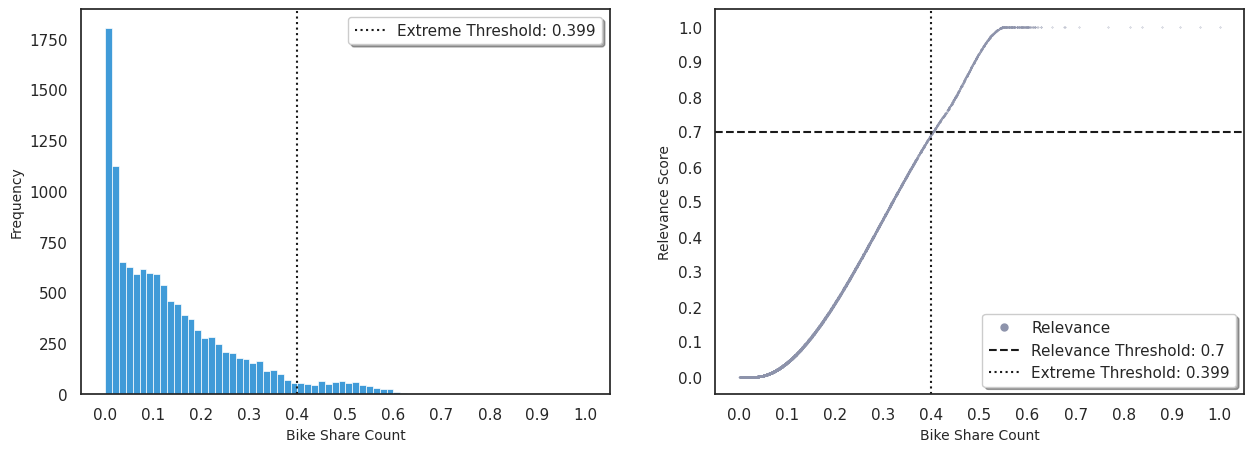

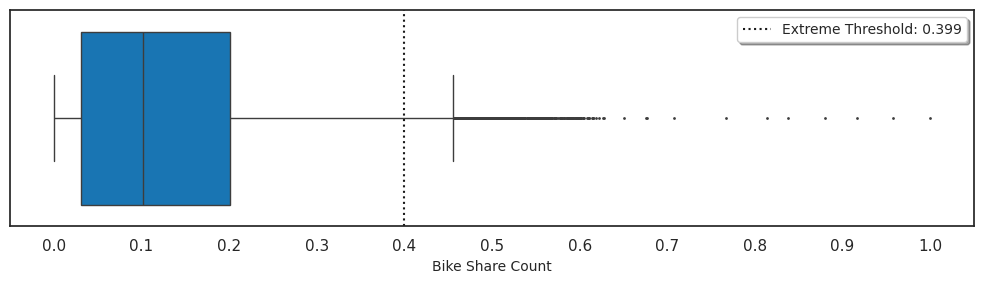

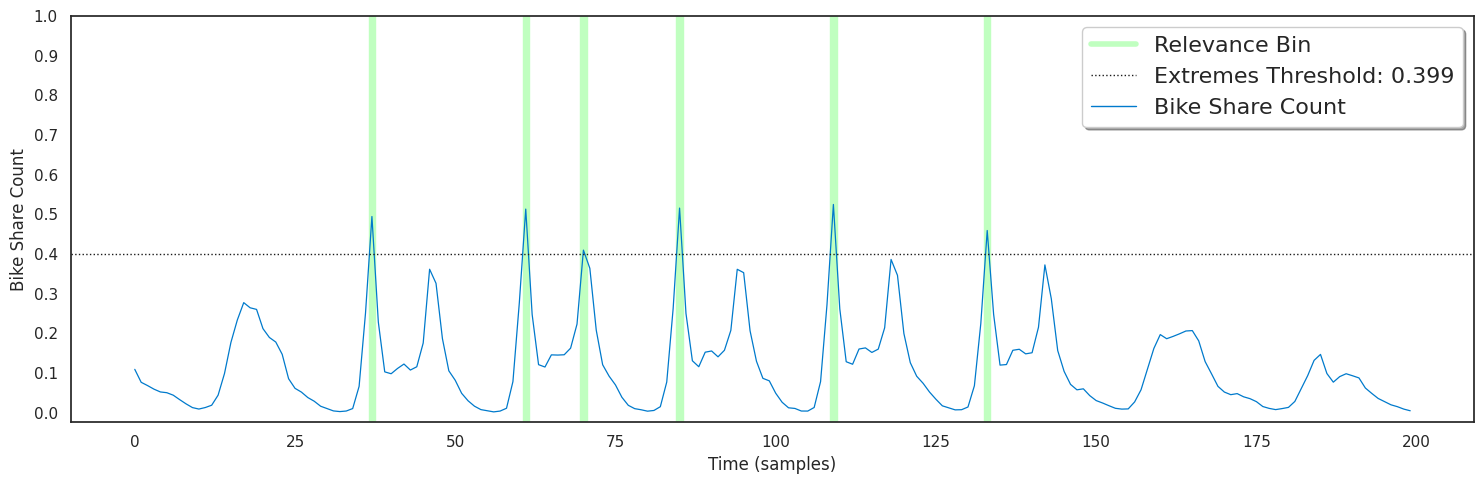

In [28]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)

#pu.PlotScaledData(data, TVAR)

r_Y_plot = RELEVANCE_FUNCTION.__call__(all_train_targets, combine=COMBINE) #relevance for plotting
k_Y_plot = [val >= RELEVANCE_THRESHOLD for val in r_Y_plot]
r_Y_plot = np.array(r_Y_plot)
k_Y_plot = np.array(k_Y_plot)

pu.PlotRelevance(all_train_targets, r_Y_plot, RELEVANCE_THRESHOLD, EXTREMES_THRESHOLD, TVAR, DATA_NAME)

#pu.PlotCaseWeightSurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)
#pu.PlotUtilitySurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)

#pu.PlotBins(all_train_targets,k_Y_plot,EXTREMES_THRESHOLD, TVAR, DATA_NAME)
pu.PlotBins(all_train_targets[1500:1700],k_Y_plot[1500:1700],EXTREMES_THRESHOLD, TVAR, DATA_NAME)

# **Resampling**

In [29]:
RES_STRATS = ["SMOTER_regular", "SMOTER_bin", "SMOTER_bin_t", "SMOTER_bin_r", "SMOTER_bin_tr", "GAN_CNN", "GAN_FNN"]

**Define GAN Models**

In [30]:
import GAN as gmod
importlib.reload(gmod)

n_gan_epochs = 1
gan_batch_size = 128

CNN_GENS=None; CNN_DISCS=None; FNN_GENS=None; FNN_DISC=None

if "GAN_CNN" in RES_STRATS:
    CNN_GENS, CNN_DISCS = gmod.getGAN(k_Xex,GAN_CNN_DIR, "CNN", SAMPLE_DIM, n_gan_epochs, gan_batch_size, RECORDER.log_print)
if "GAN_FNN" in RES_STRATS:
    FNN_GENS, FNN_DISCS = gmod.getGAN(k_Xex,GAN_FNN_DIR, "FNN", SAMPLE_DIM, n_gan_epochs, gan_batch_size, RECORDER.log_print)

RECORDER.save_param_dict({"GAN":{"nEpochs":n_gan_epochs,"batchSize": gan_batch_size}})
print("$$$$ Finished training GANs $$$$")

LOG: 00:25:43:436 Training CNN GAN with 1 epochs



 33%|████████████████████████████▎                                                        | 2/6 [00:01<00:02,  1.48it/s]

Step 1: Generator loss: 1.4399583339691162, discriminator loss: 1.3782728910446167


 50%|██████████████████████████████████████████▌                                          | 3/6 [00:02<00:02,  1.46it/s]

Step 2: Generator loss: 0.7239043712615967, discriminator loss: 0.6895638704299927


 67%|████████████████████████████████████████████████████████▋                            | 4/6 [00:02<00:01,  1.48it/s]

Step 3: Generator loss: 0.7257139682769775, discriminator loss: 0.6904618740081787


 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [00:03<00:00,  1.46it/s]

Step 4: Generator loss: 0.7281575202941895, discriminator loss: 0.6887943744659424


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.60it/s]


Step 5: Generator loss: 0.7321667075157166, discriminator loss: 0.6897642612457275
LOG: 00:25:47:195 Training FNN GAN with 1 epochs



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 107.23it/s]

Step 1: Generator loss: 1.3970309495925903, discriminator loss: 1.3797211647033691
Step 2: Generator loss: 0.6997288465499878, discriminator loss: 0.6893906593322754
Step 3: Generator loss: 0.700519859790802, discriminator loss: 0.6890482902526855
Step 4: Generator loss: 0.7013595104217529, discriminator loss: 0.6885994672775269
Step 5: Generator loss: 0.7020720839500427, discriminator loss: 0.6880671977996826
$$$$ Finished training GANs $$$$


In [31]:
import SMOTER as smtr
importlib.reload(smtr)

#import GAN as gmod
#importlib.reload(gmod)

K_SMOTE_NEIGHBORS = 3

def run_resampling(k_x, k_y, r_y, res_strats, relevance_function, relevance_threshold, combine):
    resampling_results = {}    
    _, orig_rels, orig_coms = smtr.countRelVsCom(k_x[:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
    print(f"need to gen {orig_coms - orig_rels} new rares ontop of current {orig_rels} rares to meet {orig_coms} coms")
    #Perform each variation of each resampling approach
    if "SMOTER_bin" in res_strats:
        resampling_results['SMOTER_bin'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS)
        RECORDER.log_print(f"Finished SMOTER_bin resample")
    if "SMOTER_bin_t" in res_strats:
        resampling_results["SMOTER_bin_t"] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_t resample")
    if "SMOTER_bin_r" in res_strats:
        resampling_results['SMOTER_bin_r'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=False, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_r resample")
    if "SMOTER_bin_tr" in res_strats:
        resampling_results['SMOTER_bin_tr'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=True, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_tr resample")
    #We want all the resampling approaches to return the same number of relevance and common cases:
    _, num_rel, num_com = smtr.countRelVsCom(resampling_results['SMOTER_bin'][:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
    #print(f"num relevance that reg approach is trying to match {num_rel}")
    if "GAN_CNN" in res_strats:
        for key, gen in CNN_GENS.items():
            #resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "CNN") #for testing
            resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, num_rel - orig_rels, gen, "CNN")
            RECORDER.log_print(f"Finished GAN_CNN_e{key}")
    if "GAN_FNN" in res_strats:
        for key, gen in FNN_GENS.items():
            #resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "FNN") #for testing
            resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, num_rel - orig_rels, gen, "FNN")
            RECORDER.log_print(f"Finished GAN_FNN_e{key}")
        
    if "SMOTER_regular" in res_strats:
        resampling_results['SMOTER_regular'], yyyy = smtr.regularResample(k_x, k_y, orig_coms, num_com, K_SMOTE_NEIGHBORS)
        RECORDER.log_print("Finished SMOTER_regular")
    strat_meta = [['Resampling Method','Num Relevant','Num Common','Total']]
    for strat in resampling_results.keys():
        tot, num_rel, num_com = smtr.countRelVsCom(resampling_results[strat][:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
        tab_row = [strat,str(num_rel),str(num_com),str(tot)]
        strat_meta.append(tab_row)
    tab_row = ["no_resample",str(orig_rels),str(orig_coms),str(orig_rels+orig_coms)]
    strat_meta.append(tab_row)
    
    RECORDER.log_print("Resampled sizes: \n"+tabulate(strat_meta,headers='firstrow',tablefmt='grid'))
    #RECORDER.save_sample_results_step(resampling_results, N_STEPS_IN, N_FVARS, FVARS, TVAR)
    RECORDER.save_param_dict({"SMOTE":{"kNeighbors":K_SMOTE_NEIGHBORS}})
    
    return resampling_results


#(i moved where we define RES_STRATS to be before we train the GANS)
resampling_results = run_resampling(k_X, k_Y, r_Y, RES_STRATS, RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, COMBINE)

need to gen 10777 new rares ontop of current 703 rares to meet 11480 coms
LOG: 00:25:49:868 Finished SMOTER_bin resample

LOG: 00:25:52:669 Finished SMOTER_bin_t resample

LOG: 00:25:55:387 Finished SMOTER_bin_r resample

LOG: 00:25:58:175 Finished SMOTER_bin_tr resample

LOG: 00:26:13:591 Finished GAN_CNN_e0

LOG: 00:26:13:620 Finished GAN_FNN_e0

LOG: 00:26:13:626 Finished SMOTER_regular

LOG: 00:26:13:649 Resampled sizes: 
+---------------------+----------------+--------------+---------+
| Resampling Method   |   Num Relevant |   Num Common |   Total |
+=====================+================+==============+=========+
| SMOTER_bin          |          11460 |        11480 |   22940 |
+---------------------+----------------+--------------+---------+
| SMOTER_bin_t        |          11460 |        11480 |   22940 |
+---------------------+----------------+--------------+---------+
| SMOTER_bin_r        |          11460 |        11480 |   22940 |
+---------------------+----------------+--

#### Plot Resampling Results

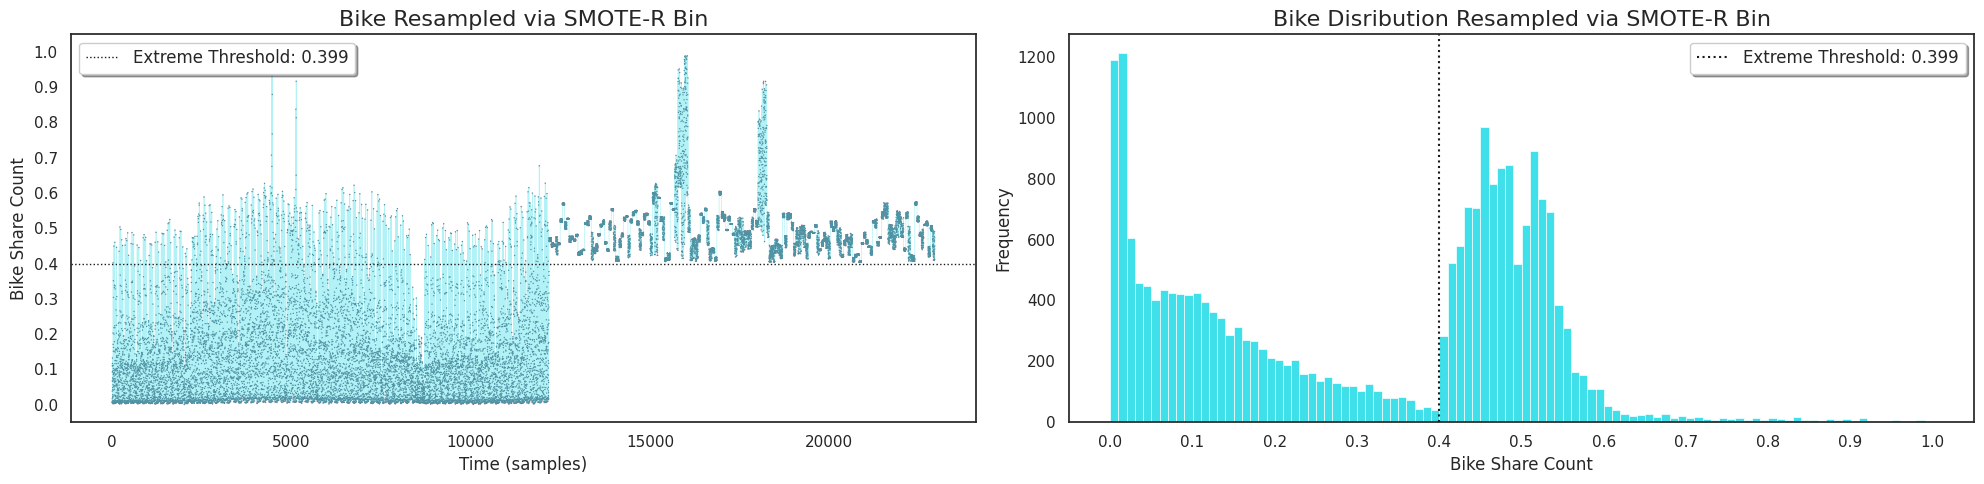

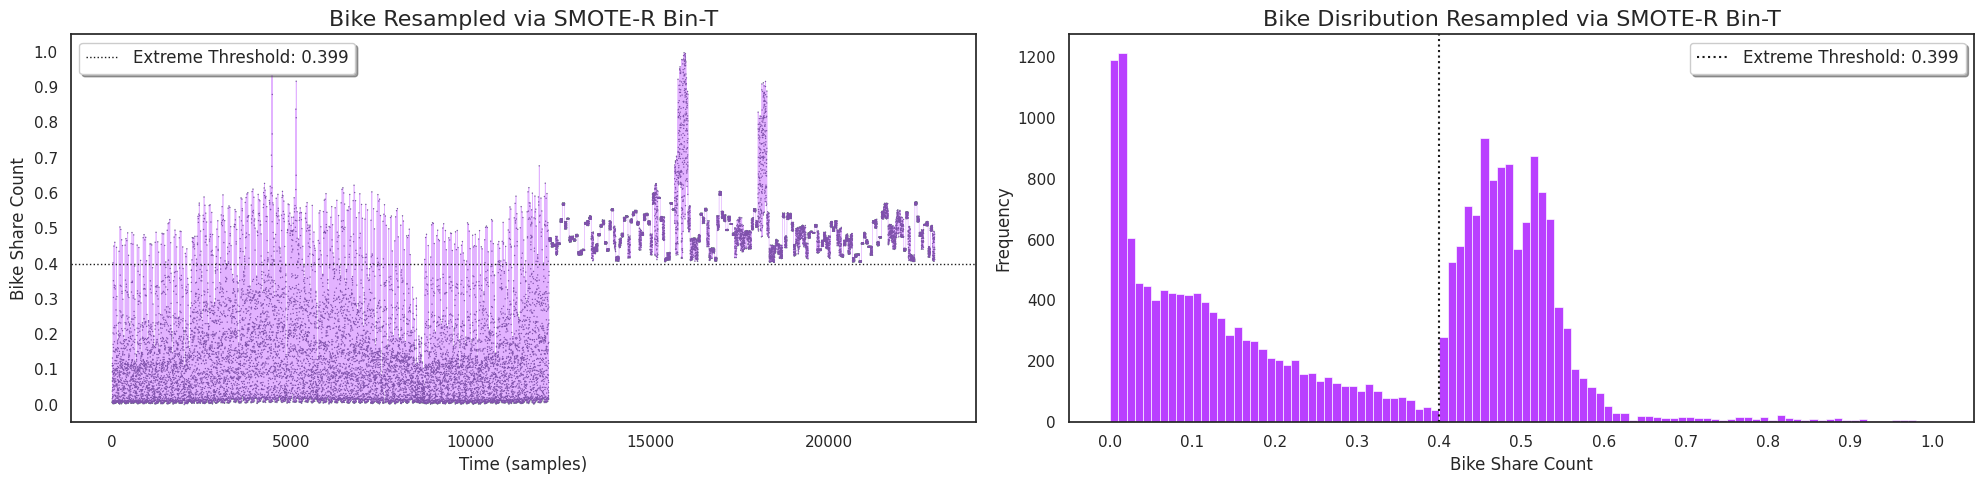

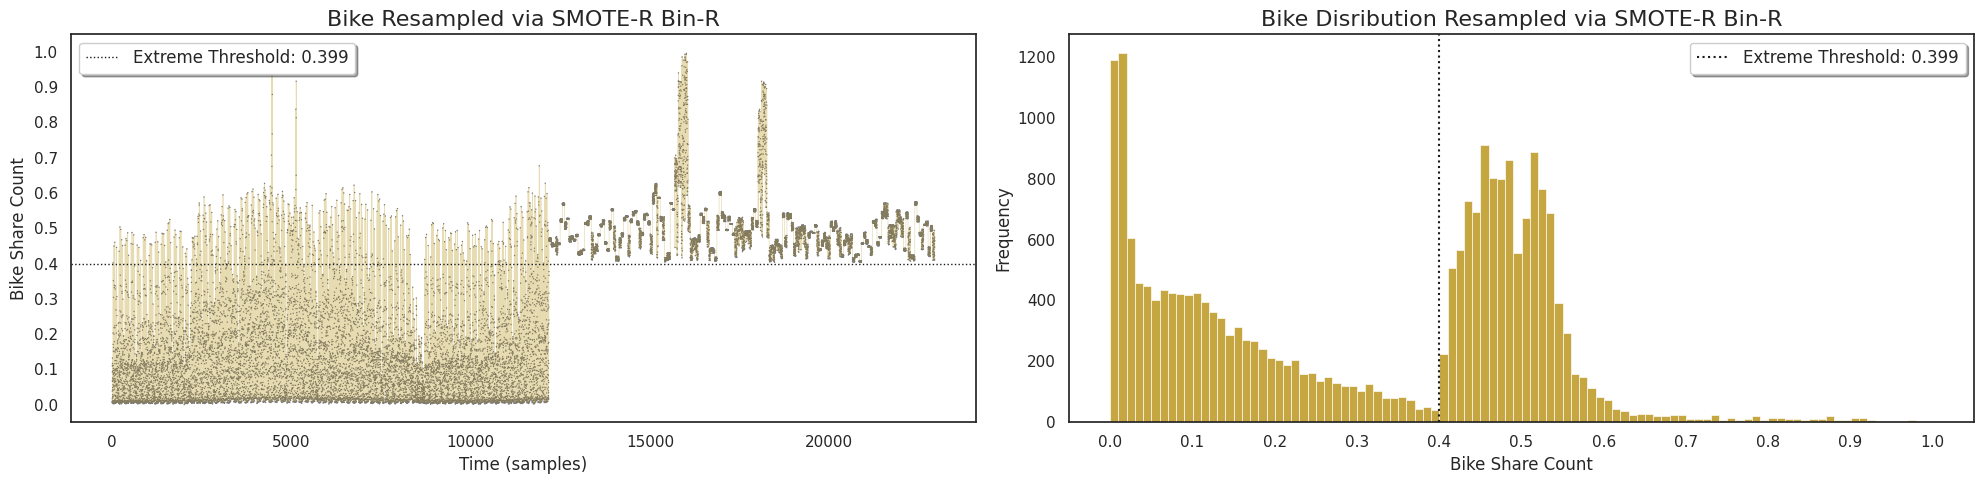

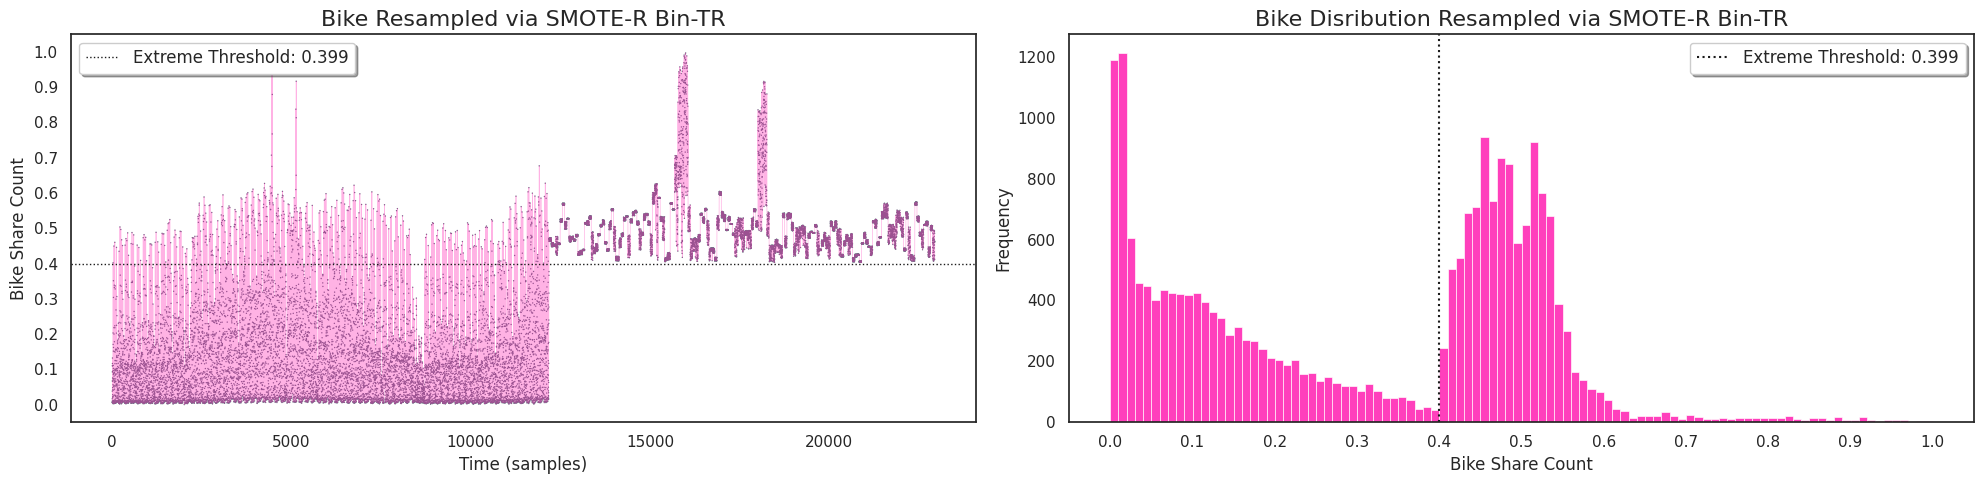

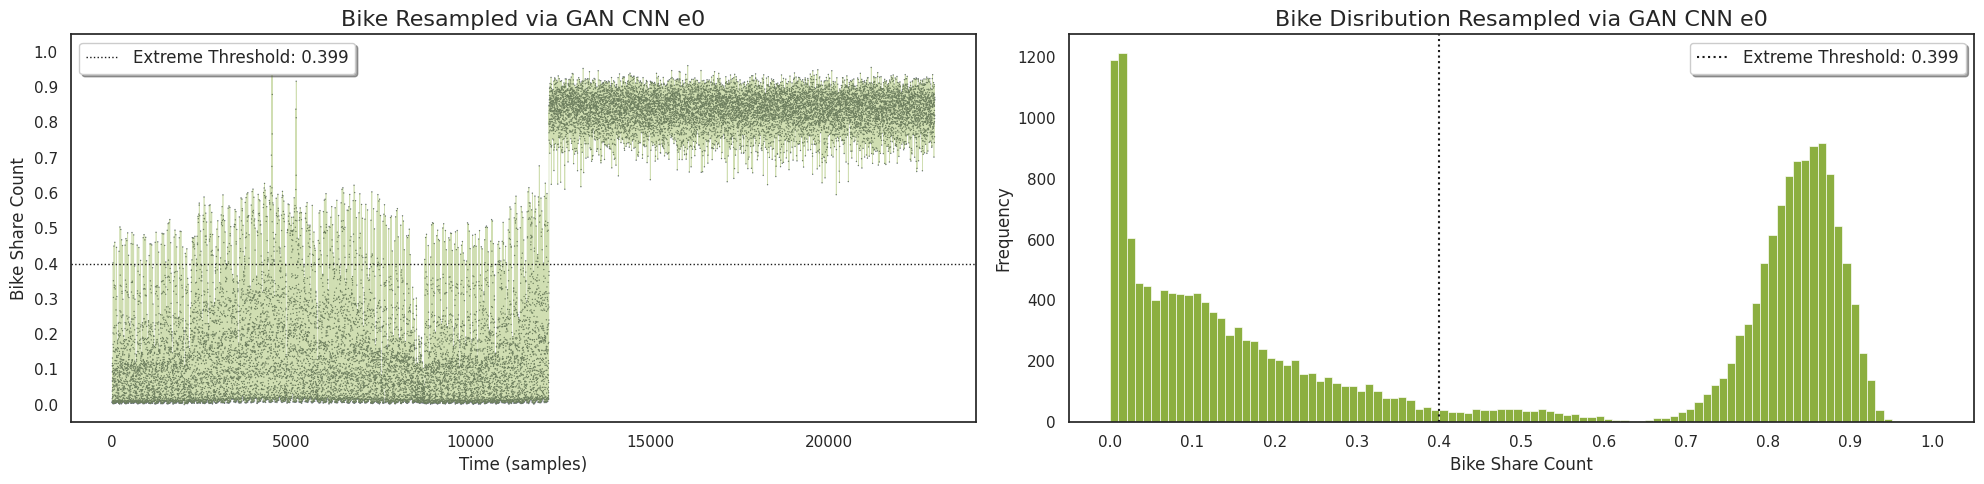

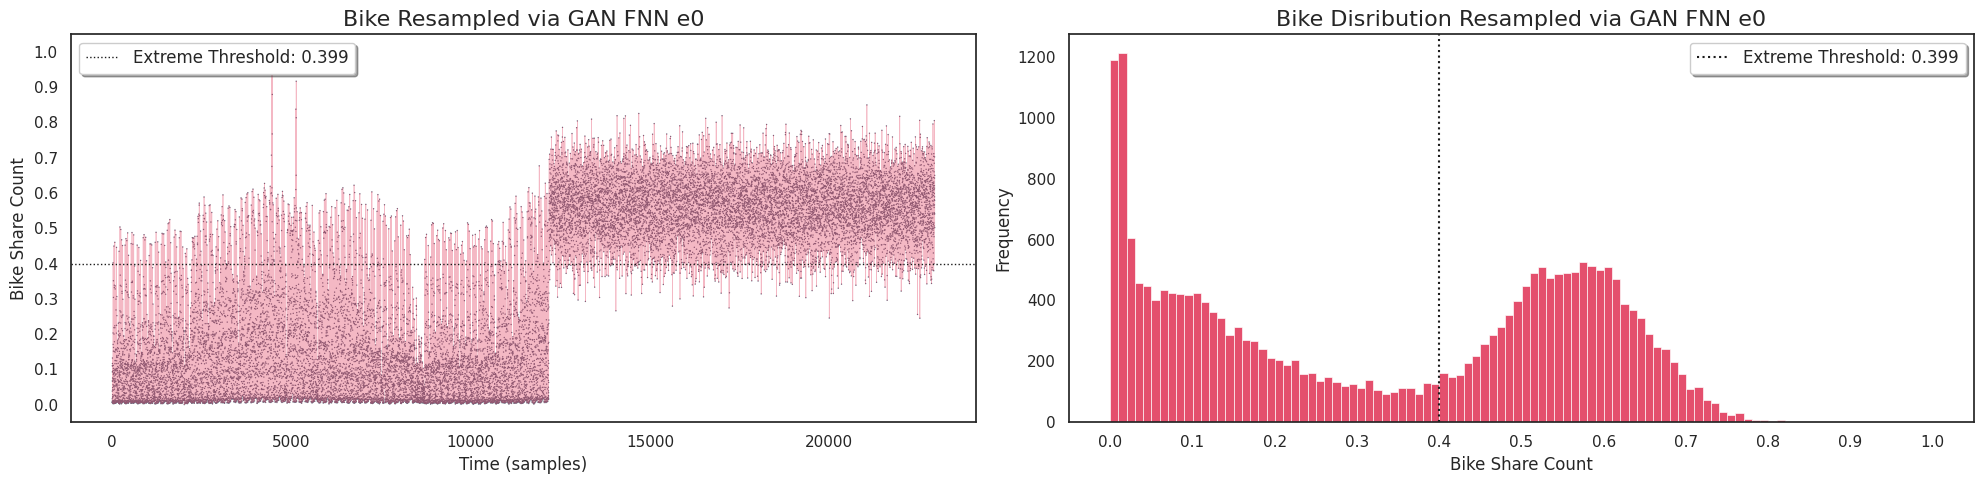

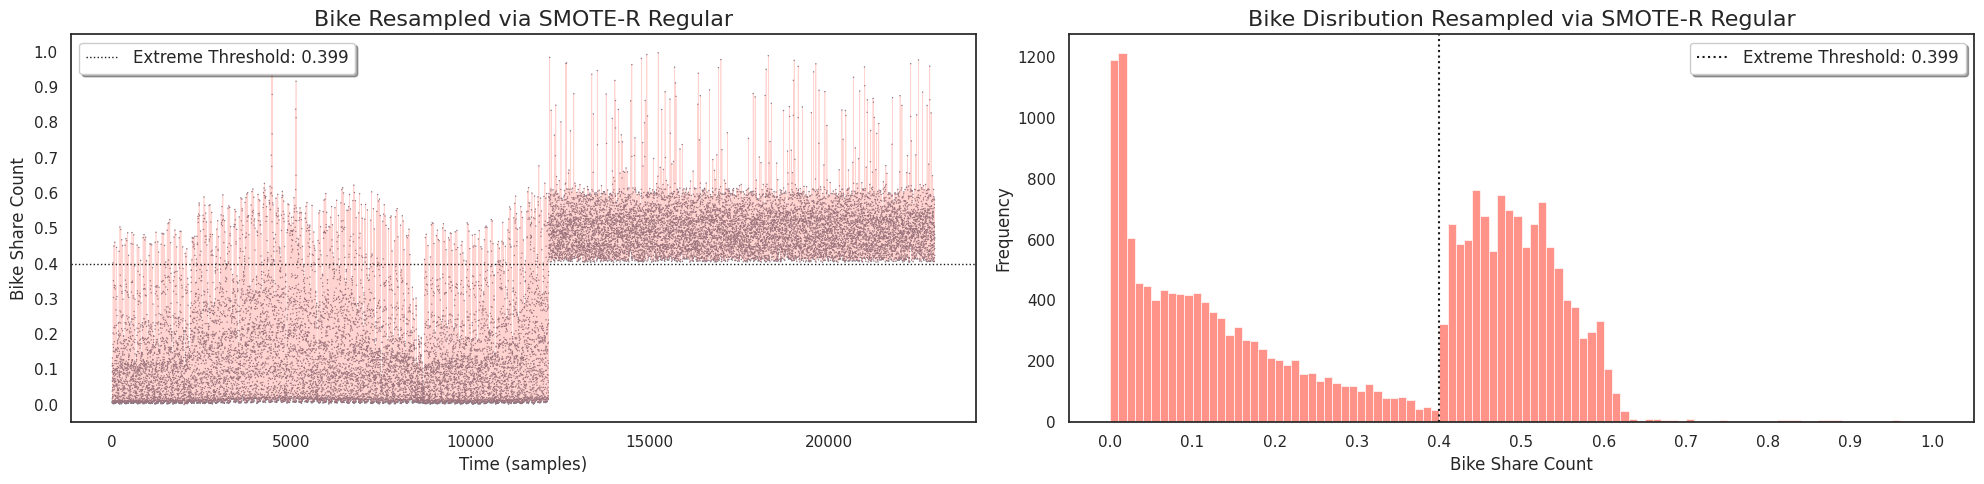

In [32]:
#import plt_utils as pu
#importlib.reload(pu)
#only plots first step out in each embedded
pu.PlotResampledResults(resampling_results, k_X.shape[0], N_STEPS_OUT,EXTREMES_THRESHOLD, TVAR, DATA_NAME)

### Remove Bad GANs

Save time training the forecasters by removing GANs that will clearly generate bad results

In [33]:
all_resampling_results = resampling_results.copy() #save a copy just incase
to_delete = ['GAN_CNN_e0', 'GAN_CNN_e10', 'GAN_CNN_e20', 'GAN_CNN_e30', 'GAN_CNN_e40', 'GAN_CNN_e50', 'GAN_CNN_e60', 'GAN_CNN_e90', 'GAN_CNN_e100', 'GAN_CNN_e110', 'GAN_FNN_e0', 'GAN_FNN_e10', 'GAN_FNN_e20', 'GAN_FNN_e30', 'GAN_FNN_e40', 'GAN_FNN_e50', 'GAN_FNN_e60', 'GAN_FNN_e70', 'GAN_FNN_e80', 'GAN_FNN_e90'] #['GAN_CNN_e10'] #specify resampling results to delete from the dictionary
print(resampling_results.keys())
for d in to_delete:
    del resampling_results[d]
print(resampling_results.keys())

dict_keys(['SMOTER_bin', 'SMOTER_bin_t', 'SMOTER_bin_r', 'SMOTER_bin_tr', 'GAN_CNN_e0', 'GAN_FNN_e0', 'SMOTER_regular'])


KeyError: 'GAN_CNN_e10'

# **Running Forecasting Experiments**

**Init Evaluator object for model eval metrics**

In [ ]:
import evaluator as ev
importlib.reload(ev)

#NOTE: evaler_params must include CaseWeight else errors in MODEL_LSTM
evaluator_params = { "RMSE": {},
                     "RMSERare": {},
                     "Utility": {'m':0.5},
                     "CaseWeight": {'m':0.5},
                     "PrecisionRecall": {},
                     "FScore": {'beta':0.5},
                     #"RelevanceROC": {},
                   }
EVALERS = {}
for f in FORECASTERS:
    EVALERS[f] = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)

#EVALER = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)
RECORDER.save_param_dict({"Evaluator":evaluator_params})

**Train and evaluate an LSTM for each resampling strategy**

In [ ]:
NUM_EXPERIMENTS = 1

def main(time_step, X_train, X_test, Y_train, Y_test, resampling_results, evalers, recorder, train_params):   
    recorder.log_print(f"Starting forecasting experiments with num_exps: {train_params['num_exp']} and epochs: {train_params['epochs']}")
    recorder.save_param_dict({"Forecasting":{"NumExp":train_params['num_exp'], "nEpochs": train_params['epochs'], "hidden":train_params['hidden']}})
    
    forecast_results = {}
    for f in FORECASTERS:
        print(f"############## no_resample : {f} ##############")
        if f == "LSTM":
            best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_LSTM(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evalers[f], recorder.log_print)
        else:
            best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_CNN(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evalers[f], recorder.log_print)
    
        results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_train,'Y_train':Y_train,'model':best_model}
        forecast_results[f] = {}
        forecast_results[f]['no_resample'] = results
    
    
    for key in resampling_results.keys():
        res = resampling_results[key]
        X_res = res[:,:(N_STEPS_IN*N_FVARS)]
        X_res = X_res.reshape((X_res.shape[0],N_STEPS_IN,N_FVARS))
        Y_res = res[:,(N_STEPS_IN*N_FVARS):]
        for f in FORECASTERS:
            print(f"############## {key} : {f} ##############")
            if f == "LSTM":
                best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_LSTM(X_res, X_test, Y_res, Y_test, key, train_params, evalers[f], recorder.log_print)
            else:
                best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_CNN(X_res, X_test, Y_res, Y_test, key, train_params, evalers[f], recorder.log_print)
        
            results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_res,'Y_train':Y_res,'model':best_model}
            forecast_results[f][key] = results
    
    return forecast_results

TRAIN_PARAMS = {
        'num_exp': NUM_EXPERIMENTS, 
        'n_steps_in': N_STEPS_IN,
        'n_steps_out': N_STEPS_OUT,
        'epochs': 1,
        'hidden': 100,
        'forecast_dir': FORECAST_DIR,
        'n_fvars': N_FVARS
    }

forecast_results = main(N_STEPS_IN, X_train, X_test, Y_train, Y_test, resampling_results, EVALERS, RECORDER, TRAIN_PARAMS)

print("$$$$ FINISHED FORECASTING EXPERIMENTS $$$$")

## *SAVE EVALER RESULTS ---- DON'T FORGET*

In [ ]:
for f in FORECASTERS:
    RECORDER.save_all_evaler_exps(EVALERS[f].getResultsDf(), f)

### Plot Actual vs Predicted

In [ ]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
#print(forecast_results)
#PLOT PRED VS ACTUAL + SAVE_EVAL_RESULTS
for f in FORECASTERS:
    for key in forecast_results[f].keys():
        y_predict_test = forecast_results[f][key]['predict_test']
        #Plot a single Actual vs Predicted figure for only one chosen step out: 0 for first step
        pu.PlotPredVsActual1D(Y_test, y_predict_test, key, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f, 0)
        #Plot a Actual vs Predicted for all steps out in one figure
        pu.PlotPredVsActualSteps(Y_test, y_predict_test, key, EXTREMES_THRESHOLD, TVAR, DATA_NAME, N_STEPS_OUT, f)
        #Save forecasting model
        RECORDER.save_LSTM(forecast_results[f][key]['model'], key)
        #TODO: save CNN and LSTM with same function

### Record KS Statistic and Plot Extremes Distribution for Each Resampling Strategy

In [ ]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
from scipy.stats import ks_2samp
import scipy.stats as stats

step_out = 0
#get extremes for original data
y_orig_rel = RELEVANCE_FUNCTION.__call__(Y_train[:,step_out])
rare_mask = [val >= RELEVANCE_THRESHOLD for val in y_orig_rel]
y_orig_rare = Y_train[rare_mask]
ks_results = []
for key, res in resampling_results.items():
    #get extremes for resampled data
    y_res = res[:,(N_STEPS_IN*N_FVARS):]
    y_rel = RELEVANCE_FUNCTION.__call__(y_res[:,step_out])
    rare_mask = [val >= RELEVANCE_THRESHOLD for val in y_rel]
    y_rare = y_res[rare_mask]

    # Perform the Kolmogorov-Smirnov test
    statistic, p_value = ks_2samp(y_orig_rare[:,step_out], y_rare[:,step_out])
    print(f"KS statistic: {statistic}, p-value: {p_value}")
    ks_results.append({'Res':key, 'ksStat':statistic, 'pValue':p_value})
    #Plot extremes hist and cdf for each strategy vs original data
    pu.PlotExremesDistribution(y_orig_rare, y_rare, key, step_out, EXTREMES_THRESHOLD, TVAR, DATA_NAME)
    

ks_df = pd.DataFrame(ks_results)
RECORDER.save_ks(ks_df)

### Prepare Data for Comparison Plots

If we include all strategies on the comparison plots they will be really cluttered and almost useless to the reader. In the following cell we choose the best CNN_GAN, FNN_GAN, and SMOTER_bin approach from the RMSERare of the forecasting results and only include these on the comparison plots. 

Later we'll also use this cell to load the base resampling results / eval metrics to include on the comparison plots along side the next generation of resampling strategies

In [ ]:
def calculate_mean(lst):
    return sum(lst) / len(lst)

#Combine EVALER from loaded experiments
#Combine resampling results from loaded experiments
#np.loadtxt('test.txt', delimiter=',', dtype=float)

#TODO: come up with a way to make a copy of evaler so we don't have to filter best strategies for the clustered bar plots

#best_resampling_results will contain best GANs, best SMOTERs
best_resampling_results = resampling_results.copy()
best_cnn_gan = ""
best_fnn_gan = ""
best_bin = ""

def get_best_resampling(forecaster, best, evaler, metric, recorder):
    exp_sum = evaler.getExperimentSummaryDf(metric)
    #get best CNN_GAN if used
    cnn_exp_sum = exp_sum[exp_sum['Res'].str.contains("GAN_CNN")]
    if not cnn_exp_sum.empty:
        #apply mean to all rows
        cnn_exp_sum[f"{metric}_Test_Mean"] = cnn_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = cnn_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_cnn_gan = cnn_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best CNN_GAN for {forecaster}: {best_cnn_gan}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "GAN_CNN" in key and key != best_cnn_gan]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['cnn_gan'] = best_cnn_gan
        ekey = int(best_cnn_gan.split('_')[-1][1:])
        recorder.save_gan(CNN_GENS[ekey], CNN_DISCS[ekey], "CNN", best_cnn_gan)
    
    #get best FNN_GAN if used
    fnn_exp_sum = exp_sum[exp_sum['Res'].str.contains("GAN_FNN")]
    if not fnn_exp_sum.empty:
        #apply mean to all rows
        fnn_exp_sum[f"{metric}_Test_Mean"] = fnn_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = fnn_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_fnn_gan = fnn_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best FNN_GAN for {forecaster}: {best_fnn_gan}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "GAN_FNN" in key and key != best_fnn_gan]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['fnn_gan'] = best_fnn_gan
        ekey = int(best_fnn_gan.split('_')[-1][1:])
        RECORDER.save_gan(FNN_GENS[ekey], FNN_DISCS[ekey], "FNN", best_fnn_gan)
    #get best SMOTER_bin if used
    bin_exp_sum = exp_sum[exp_sum['Res'].str.contains("SMOTER_bin")] 
    if not bin_exp_sum.empty:
        bin_exp_sum[f"{metric}_Test_Mean"] = bin_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = bin_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_bin = bin_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best SMOTER bin for {forecaster}: {best_bin}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "SMOTER_bin" in key and key != best_bin]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['bin'] = best_bin
    return best #?
                                                         

BEST_RESULTS = {}
for f in FORECASTERS:
    BEST_RESULTS[f] = {'resampling_results': resampling_results.copy(), 'cnn_gan': "", 'fnn_gan': "", "bin": ""}
    #do below stuff with argument 'f'
    BEST_RESULTS[f] = get_best_resampling(f, BEST_RESULTS[f], EVALERS[f], 'RMSERare', RECORDER) #?
    RECORDER.save_resample_results_np(BEST_RESULTS[f]['resampling_results'], f)


#load all resampling results
#COMBINE_RESAMPLING_RESULTS_DIR = Path("Sessions/Bike/2023-October-13 13-41-03-532984").joinpath("resample_results")

#add loaded resampling results to best_resampling_results
#best_resampling_results.update({file.stem: np.loadtxt(file, delimiter=',', dtype=float)
#                  for file in COMBINE_RESAMPLING_RESULTS_DIR.iterdir() if file.is_file()})

### Compare KDEs and CDFs

In [35]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
step_out = 0

#compare KDE, CDF
for f in FORECASTERS:
    pu.PlotKDECompare(Y_train, BEST_RESULTS[f]['resampling_results'], RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, step_out, N_STEPS_IN*N_FVARS, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f)    
    pu.PlotCDFCompare(Y_train, BEST_RESULTS[f]['resampling_results'], RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, step_out, N_STEPS_IN*N_FVARS, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f)    

NameError: name 'BEST_RESULTS' is not defined

### Plot Eval Results Aggregated Over All Steps

In [34]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)


def calculate_mean(lst):
    return sum(lst) / len(lst)

#Just plot these metrics:
plot_metrics = ["CaseWeight", "Utility", "RMSERare", "RMSE", "FScore"]

ts = ["Train", "Test"] #one cluster for train, one for test results

#aggs options: 
aggs = ["Mean", "Std"]
## for "Mean" we get the mean of the eval metrics over all experiments and plot its average over time steps
## for "Std" we get the std of the eval metrics over all experiments and plot its average over time steps

#for f in FORECASTERS: EVALER[f], get best_cnn_gan, best_fnn_gan, best_bin from dict
#pass an argument to plotting function to specify f
for f in FORECASTERS:
    best_cnn_gan = BEST_RESULTS[f]['cnn_gan']
    best_fnn_gan = BEST_RESULTS[f]['fnn_gan']
    best_bin = BEST_RESULTS[f]['bin']
    for metric in plot_metrics:
        df_results = EVALERS[f].getExperimentSummaryDf(metric, True)
        df_results_train = EVALERS[f].getExperimentSummaryDf(metric, False)
        df_results[f"{metric}_Train_Mean"] = df_results_train[f"{metric}_Train_Mean"]
        df_results[f"{metric}_Train_Std"] = df_results_train[f"{metric}_Train_Std"]
        # Replace with the mean of the steps out lists
        df_results[f"{metric}_Train_Mean"] = df_results[f"{metric}_Train_Mean"].apply(calculate_mean)
        df_results[f"{metric}_Test_Mean"] = df_results[f"{metric}_Test_Mean"].apply(calculate_mean)
        df_results[f"{metric}_Train_Std"] = df_results[f"{metric}_Train_Std"].apply(calculate_mean)
        df_results[f"{metric}_Test_Std"] = df_results[f"{metric}_Test_Std"].apply(calculate_mean)
        for a in aggs:
            #remove any GAN_CNNs, GAN_FNNs, and SMOTER_bin strategies from the dataframe that aren't the best
            filtered_df = df_results[((df_results['Res'].str.contains('GAN_CNN|GAN_FNN')) & ((df_results['Res'] == best_cnn_gan) | (df_results['Res'] == best_fnn_gan))) | (~df_results['Res'].str.contains('GAN_CNN|GAN_FNN'))]
            filtered_df = filtered_df[((filtered_df['Res'].str.contains('SMOTER_bin')) & (filtered_df['Res'] == best_bin)) | (~filtered_df['Res'].str.contains('SMOTER_bin'))]
            '''
            filtered_df = df_results
            if best_cnn_gan:
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('GAN_CNN')) & (filtered_df['Res'] == best_cnn_gan)) | (~filtered_df['Res'].str.contains('GAN_CNN'))]
            if best_fnn_gan:
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('GAN_FNN')) & (filtered_df['Res'] == best_fnn_gan)) | (~filtered_df['Res'].str.contains('GAN_FNN'))]
            '''
            pu.PlotTrainTestBarResults(filtered_df, metric, a, DATA_NAME, N_STEPS_OUT, f)


NameError: name 'BEST_RESULTS' is not defined

### Plot Train and Test Eval Results Clustered By Steps Out

In [ ]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)



plot_metrics = ["CaseWeight", "Utility", "RMSERare", "RMSE", "FScore"]
ts = ["Train", "Test"]
aggs = ["Mean", "Std"]
#either plot mean or std of the experiments
for f in FORECASTERS:
    best_cnn_gan = BEST_RESULTS[f]['cnn_gan']
    best_fnn_gan = BEST_RESULTS[f]['fnn_gan']
    best_bin = BEST_RESULTS[f]['bin']
    for metric in plot_metrics:
        for t in ts:
            tb = True if t == "Test" else False
            df_results = EVALERS[f].getExperimentSummaryDf(metric, tb)
            for a in aggs:
                #filter out all GAN_CNNs, GAN_FNNs or SMOTER_bins that aren't the best
                filtered_df = df_results[((df_results['Res'].str.contains('GAN_CNN|GAN_FNN')) & ((df_results['Res'] == best_cnn_gan) | (df_results['Res'] == best_fnn_gan))) | (~df_results['Res'].str.contains('GAN_CNN|GAN_FNN'))]
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('SMOTER_bin')) & (filtered_df['Res'] == best_bin)) | (~filtered_df['Res'].str.contains('SMOTER_bin'))]
                pu.PlotStepBarResults(filtered_df, metric, a, t, DATA_NAME, N_STEPS_OUT, f)